In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
import copy

In [43]:
data = pd.read_csv('Iris_data.csv')
data = data.values

IRIS2ID = dict()

for index,sss in enumerate(np.unique(data[:,4])):
    IRIS2ID[sss] = index
    
for i in range(len(data)):
    data[i][4] = IRIS2ID[data[i][4]]
print(data[:5])


[[5.0 3.3 1.4 0.2 0]
 [6.4 2.8 5.6 2.2 2]
 [6.5 2.8 4.6 1.5 1]
 [6.7 3.1 5.6 2.4 2]
 [6.3 2.8 5.1 1.5 2]]


In [44]:
X = data[:, :4]
y = data[:, 4]

In [45]:
# one vs one
def onevone(X,y,i,j):
    
    X_train = []
    y_train = []
    
    for idx in range(len(X)):
        if y[idx] == i or y[idx] == j:
            X_train.append(X[idx])
            if y[idx] == i:
                y_train.append(1)
            else:
                y_train.append(-1)
                
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    return X_train, y_train

In [46]:
class SVM(object):
    def __init__(self, X, y, polydegree, types):
        
        
        self.X = X
        self.y = y
        self.types = types
        self.poly = polydegree
        self.kerneldict = {'linear': self.linear, 'poly': self.poly_function}
        self.kernel = self.kerneldict[types]
        
        
        self.weights = np.zeros(self.X.shape[1])
        self.bias = 0.0
        
        self.alpha = np.zeros(len(self.X))
        
        self.C = 1
        self.tol = 1e-2
        self.iteration = 1000
        
        self.post_bias = np.array([None]*len(self.X))
        self.bias_mean = None
        self.bias_stdev = None
        
    def train(self):
        
        changed_alphas = 1
        
        iteration = 0
        
        while changed_alphas > 0:
            
            changed_alphas = 0
            
            kkt1, kkt2 = self.KKT2()
            for i in range(0, len(self.X)):
                if kkt1[i] or kkt2[i]: # violate multiplier
                    j = np.random.randint(1, len(self.X)) % len(self.X)
                    changed_alphas += self.updateAlpha(i, j)
                     
            iteration += 1
            
            if (iteration >0 and (iteration%100 == 0 or iteration == self.iteration or changed_alphas == 0) ):
                if self.types == 'poly':
                    train_err = np.average( self.y != np.sign(self.f())[0])
                else:
                    train_err = np.average( self.y != np.sign(self.f()))
                print("Iter %d: train acc, %3f" %(iteration, 1.0-train_err))

                
            if iteration == self.iteration:
                break
        
        self.posterior_bias()
    
    
    
    def posterior_bias(self):

        pos_alpha = self.alpha > 0
        smallerc_alpha= self.alpha < self.C
        non_bound =  pos_alpha == smallerc_alpha
        non_bound = np.where(non_bound)[0]
        
        if len(non_bound): 
            E = self.y - self.f()
            if self.types == 'poly':
                E = E[0]
            biases = E[non_bound]
            self.post_bias[non_bound] = E[non_bound]
            self.bias_mean = np.mean(biases)
            self.bias_stdev = np.sqrt(np.sum((biases - self.bias_mean)**2) / (len(biases) - 1))
            
    def linear(self, X, y):
        return np.dot(X, y)
    
    def poly_function(self, X, y):
        return (np.dot(X, y.transpose()))**self.poly
    
    def updateAlpha(self,i, j): # not change
        
        if i ==j :
            return False
        
        E_value = self.f() - self.y
        if self.types =='poly':
            E_value = E_value[0]
        
        Ei = E_value[i]
        Ej = E_value[j]
        
        alphai = self.alpha[i]
        alphaj = self.alpha[j]
        
        xi, xj, yi, yj = self.X[i], self.X[j], self.y[i], self.y[j]
        
        if yi == yj:
            L = max(0, alphai + alphaj - self.C)
            H = min(self.C, alphai + alphaj)
        else:
            L = max(0, alphaj - alphai)
            H = min(self.C, self.C + alphaj - alphai)
        
        if L == H:
            return False
        
        eta = self.kernel(xi, xi) + self.kernel(xj, xj) - 2*self.kernel(xi, xj)
        
        if eta <= 0:
            return False
        
        alphaj_new = alphaj + yj*(Ei - Ej) / eta
        
        if alphaj_new < L:
            alphaj_new = L
        
        if alphaj_new > H:
            alphaj_new = H
        
        alphai_new = alphai + yi*yj*(alphaj - alphaj_new)
        
        delta_ai = alphai_new - alphai
        delta_aj = alphaj_new - alphaj
        
        if self.types == 'linear':
            self.weights = self.weights + delta_ai*yi*xi + delta_aj*yj*xj
         
        # stop
        bi = self.bias - Ei - delta_ai*yi*self.kernel(xi, xi) - delta_aj*yj*self.kernel(xi, xj)
        bj = self.bias - Ej - delta_ai*yi*self.kernel(xi, xj) - delta_aj*yj*self.kernel(xj, xj)
        
        self.bias = (bi + bj)/2
        if (alphai_new > 0 and alphai_new < self.C):
            self.bias = bi
        if (alphaj_new > 0 and alphaj_new < self.C):
            self.bias = bj
            
        self.alpha[i] = alphai_new
        self.alpha[j] = alphaj_new
        
        return True
    
    def f(self):
        
        if self.bias_mean:
            b = self.bias_mean
        else:
            b = self.bias
       
        if self.types == 'linear':
            return self.kernel(self.X, self.weights) + b
        else:
            return np.array([np.dot(self.alpha*self.y, self.kernel(self.X, self.X)) + b ])
    
    def KKT2(self):
        
        R = self.y*(self.f() - self.y)
        if self.types == 'poly':
            R = R[0]
        
        kkt1 = R < -self.tol
        kkt1_2 = self.alpha < self.C
        kkt1 = kkt1 == kkt1_2 # and
        
        kkt2 = R > self.tol
        kkt2_1 = self.alpha > 0
        kkt2 = kkt2 == kkt2_1
        
        return kkt1, kkt2
        

In [47]:
X_two = X[:,:2]

weights = []
bias = []
for i in range(2):
    for j in range(i+1,3):
        X_train,y_train =  onevone(X_two,y,i,j)
        print('*'*80)
        print('label: %d, label: %d' % (i, j))
        svm = SVM(X_train,y_train,polydegree =2, types = 'linear')
        svm.train() 
        weights.append(svm.weights)
        bias.append(svm.bias)

********************************************************************************
label: 0, label: 1
Iter 100: train acc, 0.990000
Iter 152: train acc, 1.000000
********************************************************************************
label: 0, label: 2
Iter 100: train acc, 0.990000
Iter 193: train acc, 0.990000
********************************************************************************
label: 1, label: 2
Iter 71: train acc, 0.730000


In [48]:
def meshgrid(x1, x2):

    x_min, x_max = x1.min() - 1, x1.max() + 1
    y_min, y_max = x2.min() - 1, x2.max() + 1
    x_pos, y_pos = np.meshgrid(np.arange(x_min, x_max, 0.03), np.arange(y_min, y_max, 0.03))
    return x_pos, y_pos

In [49]:
def predict(x_pos, y_pos, ij, weights, bias, x_train = None, types = 'linear'):
    classification = []
    X_t = []
    y_t = []
    if types == 'poly':
        for idex in range(3):
            x_split, y_split = onevone(x_train, y, ij[idex][0], ij[idex][1])
            X_t.append(x_split)
            y_t.append(y_split)
        
    for x1,x2 in zip(x_pos.ravel(), y_pos.ravel()):
        pred = [0,0,0]
        for i in range(3):
            if types == 'poly':
                val = poly(weights[i], bias[i], [x1,x2], X_t[i], y_t[i], 2)
            else:
                val = np.dot([x1,x2], weights[i])+ bias[i]
            val = np.sign(val)
            if val >=0:
                pred[ij[i][0]]+= 1
            else:
                pred[ij[i][1]]+= 1
        classification.append(pred)
    classification = np.argmax(classification, axis=1)
    classification = classification.reshape(x_pos.shape)
    return classification

# (1)

In [50]:
truth = [[],[],[]]
truth[0] = X_two[ np.where(y==0)]
truth[1] = X_two[ np.where(y==1)]
truth[2] = X_two[ np.where(y==2)]

/usr/local/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


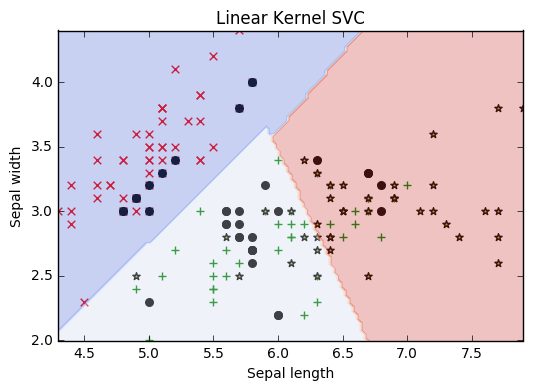

In [ ]:
xmin1 , xmax1, xmin2, xmax2 = np.min(X_two[:, 0]), np.max(X_two[:, 0]), np.min(X_two[:, 1]), np.max(X_two[:, 1])


ij = [(0, 1),(0, 2),(1, 2)]
markers = [u'x', u'+', '*']
colors = ['r','g','y']
plt.title('Linear Kernel SVC')

for m, c, X_val in zip(markers, colors, truth):
    plt.scatter(X_val[:, 0], X_val[:, 1], c=c, marker = m, s=30)

for i in range(3):
    X_split, y_split = onevone(X_two, y, ij[i][0], ij[i][1])
    support_vector = np.reshape([X_split[i] for i, v in enumerate(np.dot(X_split,weights[i])+bias[i]) if(abs(abs(v)-1)<=1e-1)], (-1,2))
    plt.scatter(support_vector[:, 0],support_vector[:, 1], c='k', marker=u'o', cmap=plt.cm.coolwarm, s=30)
    

x_pos,y_pos = meshgrid(X_two[:,0],X_two[:,1])


predict_value = predict(x_pos, y_pos, ij, weights, bias)

plt.contourf(x_pos, y_pos, predict_value, cmap=plt.cm.coolwarm, alpha=0.3)
plt.xlim(xmin1, xmax1)
plt.ylim(xmin2, xmax2)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

# (2) Poly

In [ ]:
X_two = X[:,:2]

weights = []
bias = []
for i in range(2):
    for j in range(i+1,3):
        X_train,y_train =  onevone(X_two,y,i,j)
        print('*'*80)
        print('label: %d, label: %d' % (i, j))
        svm = SVM(X_train,y_train,polydegree =2, types = 'poly')
        svm.train() 
        #svm.train() 
        weights.append(svm.alpha)
        bias.append(svm.bias)

********************************************************************************
label: 0, label: 1
Iter 100: train acc, 1.000000
Iter 200: train acc, 1.000000
Iter 300: train acc, 1.000000
Iter 400: train acc, 1.000000
Iter 500: train acc, 1.000000
Iter 600: train acc, 0.960000
Iter 700: train acc, 1.000000
Iter 800: train acc, 1.000000
Iter 900: train acc, 1.000000
Iter 1000: train acc, 1.000000
********************************************************************************
label: 0, label: 2
Iter 100: train acc, 1.000000
Iter 200: train acc, 1.000000
Iter 300: train acc, 0.980000
Iter 400: train acc, 1.000000
Iter 500: train acc, 1.000000
Iter 600: train acc, 0.990000
Iter 700: train acc, 1.000000
Iter 800: train acc, 1.000000
Iter 900: train acc, 0.990000
Iter 1000: train acc, 1.000000
********************************************************************************
label: 1, label: 2
Iter 100: train acc, 0.740000
Iter 200: train acc, 0.650000
Iter 300: train acc, 0.700000
Iter 400

In [ ]:
def poly(w, b, x, x_split, y_split, degree):
    kernel  = np.dot(x_split, x)**degree
    return np.dot(w*y_split, kernel) + b

In [ ]:
xmin1 , xmax1, xmin2, xmax2 = np.min(X_two[:, 0]), np.max(X_two[:, 0]), np.min(X_two[:, 1]), np.max(X_two[:, 1])


ij = [(0, 1),(0, 2),(1, 2)]
markers = [u'x', u'+', '*']
colors = ['r','g','y']

plt.title('Poly Kernel SVC')

for m, c, X_val in zip(markers, colors, truth):
    plt.scatter(X_val[:, 0], X_val[:, 1], c=c, marker = m, s=30)

for i in range(3):
    X_split, y_split = onevone(X_two, y, ij[i][0], ij[i][1])
    support_vector = np.reshape([X_split[i] for i, v in enumerate([poly(weights[i],bias[i],x,X_split,y_split, 2) for x in X_split])if(abs(abs(v)-1)<=1e-2)], (-1,2))
    plt.scatter(support_vector[:, 0],support_vector[:, 1], c='k', marker=u'o', cmap=plt.cm.coolwarm, s=30)

x_pos,y_pos = meshgrid(X_two[:,0], X_two[:,1])

predict_value = predict(x_pos, y_pos, ij, weights, bias, x_train = X_two, types = 'poly' )

plt.contourf(x_pos, y_pos, predict_value, cmap=plt.cm.coolwarm, alpha = 0.3)
plt.xlim(xmin1, xmax1)
plt.ylim(xmin2, xmax2)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

# LDA

In [ ]:
from scipy import linalg

# (3)

In [ ]:
class LDA(object):
    def __init__(self, X, y):
             
        X = copy.deepcopy(X)
        y = copy.deepcopy(y)
        self.xlen, self.xdim = X.shape
        self.X_train = X
        self.X_mean = X.mean(axis=0)
        self.X_train -= self.X_mean
        self.X_train = self.X_train.astype(float)

        self.y_train = y
    
    def fit(self):

        labels = np.unique(self.y_train)
        s_w = np.zeros((self.xdim, self.xdim))
        s_b = np.zeros((self.xdim, self.xdim))
        
        cov = np.cov(self.X_train.transpose())
     
        for i in labels:
            x_c = np.squeeze(self.X_train[np.where(y == i)])
            label_cov = np.cov(x_c.T)
            s_w += float(len(x_c)) / self.xlen * label_cov
        
        s_b = cov - s_w
        
        evals, evecs = linalg.eig(s_w, s_b)

        np.ascontiguousarray(evals)
        np.ascontiguousarray(evecs)

        idx = np.argsort(evals)[::-1]
        self.evecs = evecs[:, idx]
        
    def transform(self, reduce_dimension, X_train=None):
        
        evecs_dim = self.evecs[:, :reduce_dimension]
        
        if X_train == None:
            return np.dot(self.X_train, evecs_dim)
        else:
            return np.dot(X_train - self.X_mean, evecs_dim)
    
    def fit_transform(self, reduce_dim):
    
        self.fit()
        return self.transform(reduce_dim)
    

In [ ]:
lda = LDA(X, y)
x_lda = lda.fit_transform(2)

In [ ]:
lda_truth = [[],[],[]]
lda_truth[0] = x_lda[ np.where(y==0)]
lda_truth[1] = x_lda[ np.where(y==1)]
lda_truth[2] = x_lda[ np.where(y==2)]

In [ ]:
plt.title('LDA')
for m,c, X_l in zip(markers, colors, lda_truth):
    plt.scatter(X_l[:, 0], X_l[:, 1], c=c, marker=m, cmap=plt.cm.coolwarm, s = 30)

plt.xlabel('reduce1')
plt.ylabel('reduce2')
plt.show()

In [ ]:
weights = []
bias = []
for i in range(2):
    for j in range(i+1,3):
        X_train,y_train = onevone(x_lda, y, i, j)
        print('*'*80)
        print('label: %d, label: %d' % (i, j))
        svm = SVM(X_train, y_train, polydegree = 2, types = 'linear')
        svm.train() 
        weights.append(svm.weights)
        bias.append(svm.bias)

In [ ]:
xmin1 , xmax1, xmin2, xmax2 = np.min(x_lda[:, 0]), np.max(x_lda[:, 0]), np.min(x_lda[:, 1]), np.max(x_lda[:, 1])


ij = [(0,1),(0,2),(1,2)]
markers = ['*', u'+', u'x']
colors = ['r','g','y']
plt.title('SVC with linear kernel and LDA')

for m,c, X_l in zip(markers, colors, lda_truth):
    plt.scatter(X_l[:, 0], X_l[:, 1], c=c, marker=m, cmap=plt.cm.coolwarm, s = 30)

for i in range(3):
    X_split, y_split = onevone(x_lda, y, ij[i][0], ij[i][1])
    support_vector = np.reshape([X_split[i] for i, v in enumerate(np.dot(X_split,weights[i])+bias[i]) if(abs(abs(v)-1)<=1e-1)], (-1,2))
    plt.scatter(support_vector[:, 0],support_vector[:, 1],c='k',marker=u'o',cmap=plt.cm.coolwarm, s = 30)

x_pos,y_pos = meshgrid(x_lda[:,0],x_lda[:,1])
predict_value = predict(x_pos, y_pos, ij, weights, bias)

plt.contourf(x_pos, y_pos, predict_value, cmap=plt.cm.coolwarm, alpha=0.3)
plt.xlim(xmin1, xmax1)
plt.ylim(xmin2, xmax2)

plt.xlabel('reduce1')
plt.ylabel('reduce2')
plt.show()

# (4)

In [ ]:
weights = []
bias = []
for i in range(2):
    for j in range(i+1,3):
        X_train,y_train = onevone(x_lda, y, i, j)
        print('*'*80)
        print('label: %d, label: %d' % (i, j))
        svm = SVM(X_train, y_train, polydegree = 2, types = 'poly')
        svm.train() 
        weights.append(svm.alpha)
        bias.append(svm.bias)

In [ ]:
xmin1 , xmax1, xmin2, xmax2 = np.min(x_lda[:, 0]), np.max(x_lda[:, 0]), np.min(x_lda[:, 1]), np.max(x_lda[:, 1])


ij = [(0,1),(0,2),(1,2)]
markers = ['*', u'+', u'x']
colors = ['r','g','y']
plt.title('SVC with Poly kernel and LDA')

for m,c, X_l in zip(markers, colors, lda_truth):
    plt.scatter(X_l[:, 0], X_l[:, 1], c=c, marker=m, cmap=plt.cm.coolwarm, s = 30)

for i in range(3):
    X_split, y_split = onevone(x_lda, y, ij[i][0], ij[i][1])
    support_vector = np.reshape([X_split[i] for i, v in enumerate([poly(weights[i],bias[i],x,X_split,y_split, 2) for x in X_split])if(abs(abs(v)-1)<=1e-2)], (-1,2))
    plt.scatter(support_vector[:, 0],support_vector[:, 1],c='k',marker=u'o',cmap=plt.cm.coolwarm, s = 30)

x_pos,y_pos = meshgrid(x_lda[:,0],x_lda[:,1])
predict_value =  predict(x_pos, y_pos, ij, weights, bias, x_train = x_lda, types = 'poly' )

plt.contourf(x_pos, y_pos, predict_value, cmap=plt.cm.coolwarm, alpha=0.3)
plt.xlim(xmin1, xmax1)
plt.ylim(xmin2, xmax2)

plt.xlabel('reduce1')
plt.ylabel('reduce2')
plt.show()

# (5)

### 1
influence of dimension reduction and the difference:

Comapare to (1) and (3)  SVM train better  and faster when we use LDA. because LDA can make same features more closer and make speartion better. Also, it is diffcult for machine to learn so many features to classify at the same time, when we reduce features efficiently, it can make machine eaiser to classify.

### 2 

As we can see from the below, we split every features to train SVM, and the best accuracy of every classification(0&1, 0&2, 1&2) is feature4.

In [ ]:
X_feature = X[:, 0:1]

weights = []
bias = []
for i in range(2):
    for j in range(i+1,3):
        X_train,y_train =  onevone(X_feature,y,i,j)
        print('*'*80)
        print('label: %d, label: %d' % (i, j))
        svm = SVM(X_train,y_train, polydegree =2, types = 'linear')
        svm.train() 
        weights.append(svm.weights)
        bias.append(svm.bias)

In [ ]:
X_feature = X[:, 1:2]

weights = []
bias = []
for i in range(2):
    for j in range(i+1,3):
        X_train,y_train =  onevone(X_feature,y,i,j)
        print('*'*80)
        print('label: %d, label: %d' % (i, j))
        svm = SVM(X_train,y_train, polydegree =2, types = 'linear')
        svm.train() 
        weights.append(svm.weights)
        bias.append(svm.bias)

In [ ]:
X_feature = X[:, 2:3]

weights = []
bias = []
for i in range(2):
    for j in range(i+1,3):
        X_train,y_train =  onevone(X_feature,y,i,j)
        print('*'*80)
        print('label: %d, label: %d' % (i, j))
        svm = SVM(X_train,y_train, polydegree =2, types = 'linear')
        svm.train() 
        weights.append(svm.weights)
        bias.append(svm.bias)

In [ ]:
X_feature = X[:, 3:4]

weights = []
bias = []
for i in range(2):
    for j in range(i+1,3):
        X_train,y_train =  onevone(X_feature,y,i,j)
        print('*'*80)
        print('label: %d, label: %d' % (i, j))
        svm = SVM(X_train,y_train, polydegree =2, types = 'linear')
        svm.train() 
        weights.append(svm.weights)
        bias.append(svm.bias)